### 1. Import delle librerie necessarie

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

### 2. Caricamento e Preparazione dei Dati

In [23]:
# Caricamento dei dati
data = pd.read_csv('data.csv')

data = data.astype({'SampleTime': 'float64', 'SensorID': 'float64', 'Value': 'float64'})

# Visualizzazione delle prime righe per confermare il caricamento
print(data.head(5))

   SampleTime  SensorID     Value
0         0.0       2.0  0.033883
1         0.0       4.0 -0.009496
2         0.0       5.0  0.000000
3         0.0       7.0 -0.057306
4         0.0       8.0  0.029096


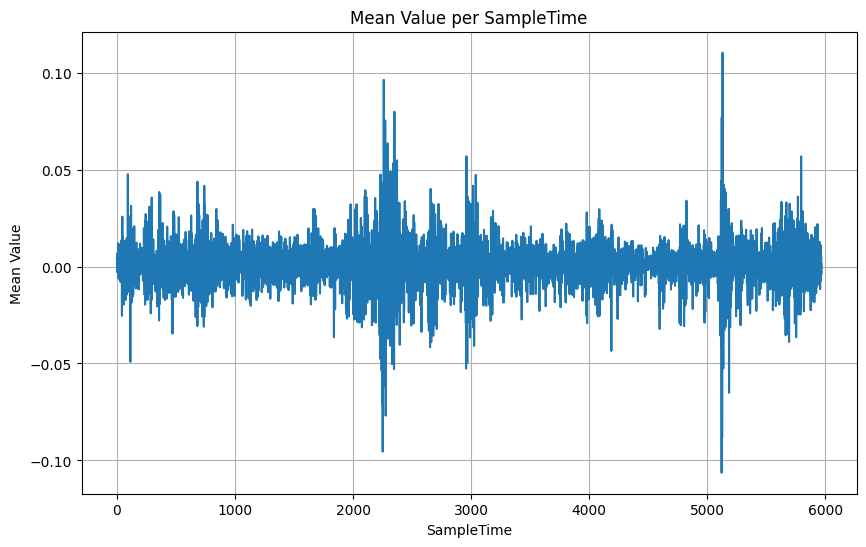

In [24]:
# Calcola la media dei valori per ogni SampleTime
mean_values = data.groupby('SampleTime')['Value'].mean()

# Plot della media dei valori per SampleTime
plt.figure(figsize=(10, 6))
plt.plot(mean_values.index, mean_values.values)
plt.xlabel('SampleTime')
plt.ylabel('Mean Value')
plt.title('Mean Value per SampleTime')
plt.grid(True)
plt.show()

### 3. Funzioni Ausiliarie

In [25]:
def offline_phase(sliding_window, x_t, k=10, fraction=0.5, random_state=42):
    """
    Calcola la distanza kNN di x_t rispetto alla sliding window divisa in S1 e S2.
    
    Parameters:
    sliding_window (np.ndarray): La finestra scorrevole dei dati.
    x_t (np.ndarray): Il punto dati corrente.
    k (int): Il numero di vicini per il calcolo delle distanze kNN.
    fraction (float): La frazione dei dati da includere in S1.
    random_state (int): Il seme per il generatore di numeri casuali.
    
    Returns:
    d_t (float): La somma delle distanze kNN di x_t.
    distances_s2 (list): Le distanze kNN di S2.
    """
    # Suddividi la finestra scorrevole in S1 e S2
    N = len(sliding_window)
    indices = np.arange(N)
    np.random.seed(random_state)
    np.random.shuffle(indices)
    split_point = int(fraction * N)
    S1 = sliding_window[indices[:split_point]]
    S2 = sliding_window[indices[split_point:]]
    
    # Calcola i kNN di x_t rispetto a S1
    nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(S1)
    distance, _ = nbrs.kneighbors([x_t])
    d_t = distance.sum()
    
    # Calcola i kNN per ogni punto in S2 rispetto a S1
    distances_S2 = []
    for s2_point in S2:
        distance, _ = nbrs.kneighbors([s2_point])
        distances_S2.append(distance.sum())

    distances_S2 = sorted(distances_S2)
    
    return d_t, distances_S2



### 4. Inizializzazione

In [26]:
# Inizializzazione delle variabili per la fase online
g_t = 0  # Statistica decisionale iniziale
h = 25 # Soglia decisionale
alpha = 0.2 # Livello di significatività
anomalies = []  # Lista per memorizzare le anomalie rilevate

# Inizializzazione del tempo t
W = 100  # Ampiezza della finestra scorrevole
t = W  # Inizializza t in modo che ci siano almeno W istanti precedenti

# Ottieni i valori dei sensori ordinati per SampleTime e SensorID
sensor_values = data.pivot(index='SampleTime', columns='SensorID', values='Value').fillna(0)
print(f"Dimensioni di sensor_values: {sensor_values.shape}")

# Definisci la lunghezza del ciclo
num_iterations = len(sensor_values) - W  # Assicurati di non superare la lunghezza dei dati

Dimensioni di sensor_values: (5967, 999)


### 5. Rilevamento anomalie

In [27]:
# Ciclo per elaborare i nuovi dati con barra di avanzamento
for i in tqdm(range(num_iterations)):
    # Crea la finestra scorrevole
    sliding_window = sensor_values.iloc[t-W:t].values
    
    # Ottieni il nuovo punto dati x_t
    x_t = sensor_values.iloc[t].values
    
    # Calcola i k vicini più prossimi di x_t tra i dati nella finestra scorrevole
    d_t, distances_S2 = offline_phase(sliding_window, x_t)
    
    # Calcola p_t
    p_t = sum(d > d_t for d in distances_S2) / len(distances_S2)

    # Gestisci il caso di p_t pari a zero
    if p_t == 0:
        p_t = 1/len(distances_S2)
    
    # Aggiorna la statistica decisionale g_t
    s_t = np.log(alpha / p_t)
    g_t = max(0, g_t + s_t)
    
    # Controlla se g_t supera la soglia h
    if g_t >= h:
        print(f"Anomalia rilevata al tempo t={t} con g_t={g_t}")
        print(f"Valore medio di x_t: {np.mean(x_t)}")
        anomalies.append(sensor_values.index[t])  # Salva l'istante di tempo dell'anomalia
        g_t = 0  # Resetta g_t
    
    t += 1

 10%|█         | 601/5867 [00:26<03:40, 23.92it/s]

Anomalia rilevata al tempo t=697 con g_t=25.0698198926939
Valore medio di x_t: 0.015865586586586586


 37%|███▋      | 2167/5867 [01:31<02:34, 24.01it/s]

Anomalia rilevata al tempo t=2262 con g_t=25.634489698900737
Valore medio di x_t: 0.028704015015015013


 86%|████████▌ | 5026/5867 [03:30<00:35, 23.61it/s]

Anomalia rilevata al tempo t=5123 con g_t=25.68451685767678
Valore medio di x_t: -0.039507266266266265


100%|██████████| 5867/5867 [04:05<00:00, 23.85it/s]


### 6. Grafico Anomalie

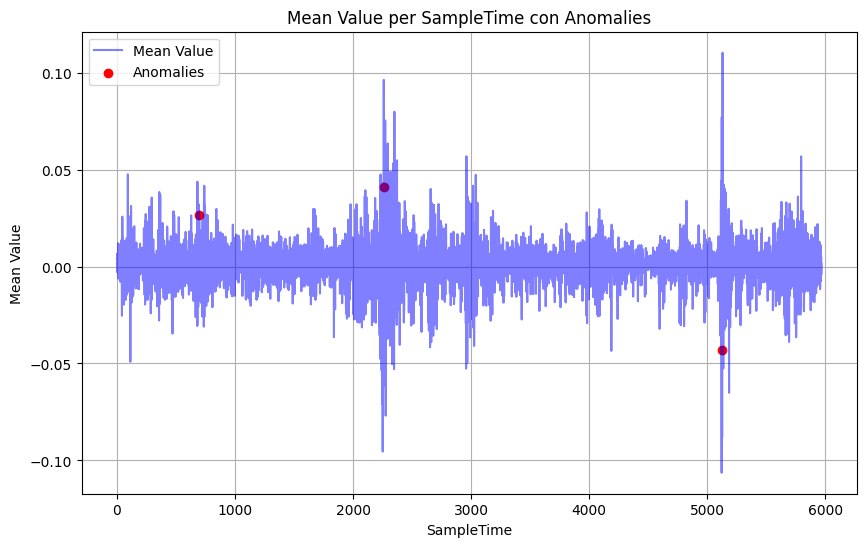

In [28]:
# Plot dei dati
plt.figure(figsize=(10, 6))
plt.plot(mean_values.index, mean_values.values, color='blue', alpha=0.5, label='Mean Value')
if anomalies:
    anomaly_times = pd.Series([1] * len(anomalies), index=anomalies)
    plt.scatter(anomaly_times.index, mean_values[anomalies], color='red', label='Anomalies')
plt.xlabel('SampleTime')
plt.ylabel('Mean Value')
plt.title('Mean Value per SampleTime con Anomalies')
plt.legend()
plt.grid(True)
plt.show()